In [1]:
!pip install tensorflow==2.12.0
import tensorflow as tf
print(tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 27.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

In [2]:
import keras
print(keras.__version__)

2.12.0


In [3]:



import cv2
import numpy as np

def label_to_numpy(labels):
  final_labels = np.zeros((len(labels), 4))
  for i in range(len(labels)):
    label = labels[i]
    if label == 'Attentive':
      final_labels[i,:] = np.array([1, 0, 0, 0])
    if label == 'DrinkingCoffee':
      final_labels[i,:] = np.array([0, 1, 0, 0])
    if label == 'UsingMirror':
      final_labels[i,:] = np.array([0, 0, 1, 0])
    if label == 'UsingRadio':
      final_labels[i,:] = np.array([0, 0, 0, 1])
  return final_labels

def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = shear)
  return augment(data, fun)

def flip_left_right(data):
  fun = augmenters.Fliplr()
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud()
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    metadata = metadata[keep_idx]

    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])

    metadata = pd.concat( [metadata_train, metadata_test] )

    return metadata

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])

    metadata = pd.concat( [metadata_train, metadata_test] )

    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)

class helpers:
  #### PLOTTING
  def plot_image(data, num_ims, figsize=(8,6), labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    print(data.shape)
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(-1,image_shape[0],image_shape[1],image_shape[2])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest

    nrows=int(np.sqrt(num_ims))
    ncols=int(np.ceil(num_ims/nrows))
    print(nrows,ncols)
    count=0
    if nrows==1 and ncols==1:
      print('Label: %s'%label)
      plt.imshow(image)
      plt.show()
    else:
      print(labels)
      fig = plt.figure(figsize=figsize)
      for i in range(nrows):
        for j in range(ncols):
          if count<num_ims:
            fig.add_subplot(nrows,ncols,count+1)
            plt.imshow(image[count])
            count+=1
      fig.set_size_inches(18.5, 10.5)
      plt.show()



  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.25, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 1)
    ax.set_ylim([0.01, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params, dropout = 0.5):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params, dropout = 0.5):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(dropout))

    model.add(Dense(units = 64, activation = 'relu'))


    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = tensorflow.keras.optimizers.RMSprop(lr=1e-4)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

  def TransferClassifier(name, nn_params):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(1024, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(512, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(nn_params['output_neurons'],
                           activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])

    return expert_model

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121

from imgaug import augmenters

### defining project variables
# file variables
image_data_url       = 'https://drive.google.com/uc?id=1qmTuUyn0525-612yS-wkp8gHB72Wv_XP'
metadata_url         = 'https://drive.google.com/uc?id=1OfKnq3uIT29sXjWSZqOOpceig8Ul24OW'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 4
nn_params['loss']              = 'categorical_crossentropy'
nn_params['output_activation'] = 'softmax'

###
gdown.download(image_data_url, image_data_path , True)
gdown.download(metadata_url, metadata_path , True)


### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_image = lambda data, num_ims,figsize=(8,6), labels = [], index = None: helpers.plot_image(data = data, num_ims=num_ims, figsize=figsize,labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

In [4]:
# grab tools from our tensorflow and keras toolboxes
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers

In [5]:
# create our model by specifying and compiling it
# train model
model = Sequential()
model.add(Dense(4, input_shape=(3,),activation = 'relu'))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error'])

In [6]:
# grab tools from our tensorflow and keras toolboxes
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers

In [7]:

model_1 = Sequential()
model_1.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1.add(Dense(2, activation = 'softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [8]:
model_2 = Sequential()
model_2.add(Flatten(input_shape = (64, 64, 3)))
### FILL IN YOUR CODE HERE
model_2.add(Dense(128, activation = 'relu' ))
model_2.add(Dense(4, activation = 'softmax'))
model_2.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=1e-4, momentum=0.95), metrics = ['accuracy'])
### END CODE

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
# define our monitor.
monitor = ModelCheckpoint('./model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#get the train data and test data
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()

# Reshape the data.
train_data = train_data.reshape([-1, 64, 64, 3])
test_data = test_data.reshape([-1, 64, 64, 3])

# Convert string labels into numpy arrays.
train_labels = label_to_numpy(train_labels)
test_labels = label_to_numpy(test_labels)

#fit model
history = model_2.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])


Epoch 1/10
211/211 [==============================] - 8s 7ms/step - loss: 1.0985 - accuracy: 0.5165 - val_loss: 9.0888 - val_accuracy: 0.2989
Epoch 2/10
211/211 [==============================] - 1s 6ms/step - loss: 1.3102 - accuracy: 0.3553 - val_loss: 1.2981 - val_accuracy: 0.3641
Epoch 3/10
211/211 [==============================] - 1s 6ms/step - loss: 0.8931 - accuracy: 0.5094 - val_loss: 1.7282 - val_accuracy: 0.3359
Epoch 4/10
211/211 [==============================] - 1s 5ms/step - loss: 1.4957 - accuracy: 0.2601 - val_loss: 1.3880 - val_accuracy: 0.2500
Epoch 5/10
211/211 [==============================] - 1s 4ms/step - loss: 1.3887 - accuracy: 0.2460 - val_loss: 1.3854 - val_accuracy: 0.2783
Epoch 6/10
211/211 [==============================] - 1s 4ms/step - loss: 1.3877 - accuracy: 0.2457 - val_loss: 1.3870 - val_accuracy: 0.2500
Epoch 7/10
211/211 [==============================] - 1s 4ms/step - loss: 1.3874 - accuracy: 0.2485 - val_loss: 1.3852 - val_accuracy: 0.2543
Epoch 

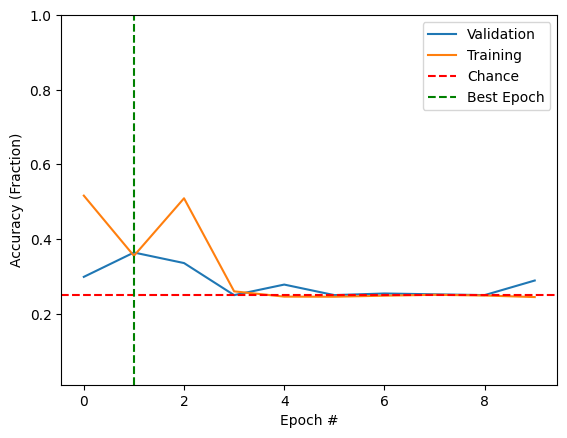

In [11]:
#plot
plot_acc(history)


In [13]:
#build and compile cnn
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), input_shape=(64,64,3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = 4, activation = 'softmax'))


# compile the network
cnn.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-3, momentum=0.95), metrics=['accuracy'])


In [14]:
#fit model (100 epochs)
history = cnn.fit(train_data, train_labels, epochs = 100, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])


Epoch 1/100
211/211 [==============================] - 8s 11ms/step - loss: 0.5221 - accuracy: 0.7973 - val_loss: 1.7652 - val_accuracy: 0.3967
Epoch 2/100
211/211 [==============================] - 2s 8ms/step - loss: 0.0402 - accuracy: 0.9874 - val_loss: 2.0027 - val_accuracy: 0.4717
Epoch 3/100
211/211 [==============================] - 2s 7ms/step - loss: 0.0123 - accuracy: 0.9964 - val_loss: 2.4310 - val_accuracy: 0.4250
Epoch 4/100
211/211 [==============================] - 2s 7ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 3.0567 - val_accuracy: 0.4261
Epoch 5/100
211/211 [==============================] - 2s 7ms/step - loss: 7.1343e-04 - accuracy: 0.9999 - val_loss: 3.2580 - val_accuracy: 0.4435
Epoch 6/100
211/211 [==============================] - 1s 7ms/step - loss: 3.4233e-04 - accuracy: 1.0000 - val_loss: 3.1366 - val_accuracy: 0.4598
Epoch 7/100
211/211 [==============================] - 2s 7ms/step - loss: 1.6480e-04 - accuracy: 1.0000 - val_loss: 3.3489 - val_acc

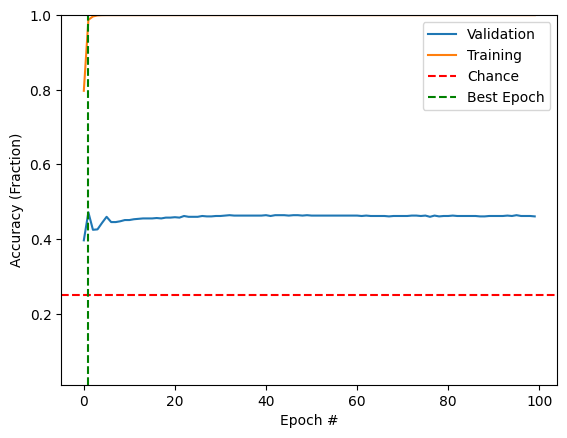

In [15]:
#plot
plot_acc(history)


In [16]:
#get data first
train_data, train_labels = get_train_data(flatten=True)
test_data, test_labels = get_test_data(flatten=True)

train_data = train_data.reshape([-1, 64, 64, 3])
test_data = test_data.reshape([-1, 64, 64, 3])

train_labels = label_to_numpy(train_labels)
test_labels = label_to_numpy(test_labels)


transfer = TransferClassifier(name = 'VGG16')
transfer.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])


58889256/58889256 [==============================] - 1s 0us/step


Epoch 1/10
211/211 [==============================] - 17s 58ms/step - loss: 1.3935 - accuracy: 0.2501 - val_loss: 1.3882 - val_accuracy: 0.2500
Epoch 2/10
211/211 [==============================] - 10s 50ms/step - loss: 1.3884 - accuracy: 0.2467 - val_loss: 1.3880 - val_accuracy: 0.2500
Epoch 3/10
211/211 [==============================] - 10s 50ms/step - loss: 1.3881 - accuracy: 0.2534 - val_loss: 1.3896 - val_accuracy: 0.2500
Epoch 4/10
211/211 [==============================] - 11s 51ms/step - loss: 1.3886 - accuracy: 0.2384 - val_loss: 1.3869 - val_accuracy: 0.2500
Epoch 5/10
211/211 [==============================] - 10s 50ms/step - loss: 1.3877 - accuracy: 0.2461 - val_loss: 1.3886 - val_accuracy: 0.2500
Epoch 6/10
211/211 [==============================] - 10s 50ms/step - loss: 1.3884 - accuracy: 0.2375 - val_loss: 1.3874 - val_accuracy: 0.2500
Epoch 7/10
211/211 [==============================] - 11s 50ms/step - loss: 1.3883 - accuracy: 0.2458 - val_loss: 1.3871 - val_accuracy:

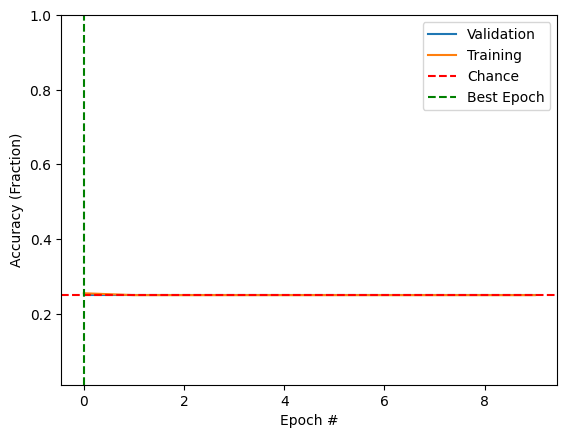

In [ ]:
plot_acc(transfer.history)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
# load the vgg network that is an 'expert' at 'imagenet'
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (64, 64, 3))

In [ ]:
vgg_model = Sequential()
vgg_model.add(vgg_expert)

In [ ]:
# add the extra layers here
vgg_model = Sequential()
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(4, activation = 'sigmoid'))



In [ ]:
# compile model
vgg_model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr = 1e-4, momentum = 0.95), metrics = ['accuracy'])

In [ ]:
#fit model
vgg_model.fit(train_data, train_labels, epochs = 20, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])


Epoch 1/20
211/211 [==============================] - 3s 8ms/step - loss: 1.3875 - accuracy: 0.2589 - val_loss: 1.3896 - val_accuracy: 0.2500
Epoch 2/20
211/211 [==============================] - 1s 6ms/step - loss: 1.3895 - accuracy: 0.2448 - val_loss: 1.3861 - val_accuracy: 0.3957
Epoch 3/20
211/211 [==============================] - 1s 6ms/step - loss: 1.3881 - accuracy: 0.2469 - val_loss: 1.3851 - val_accuracy: 0.2500
Epoch 4/20
211/211 [==============================] - 1s 5ms/step - loss: 1.3876 - accuracy: 0.2497 - val_loss: 1.3865 - val_accuracy: 0.2685
Epoch 5/20
211/211 [==============================] - 1s 4ms/step - loss: 1.3878 - accuracy: 0.2528 - val_loss: 1.3857 - val_accuracy: 0.2500
Epoch 6/20
211/211 [==============================] - 1s 4ms/step - loss: 1.3867 - accuracy: 0.2615 - val_loss: 1.3869 - val_accuracy: 0.3402
Epoch 7/20
211/211 [==============================] - 1s 4ms/step - loss: 1.3876 - accuracy: 0.2595 - val_loss: 1.3854 - val_accuracy: 0.2435
Epoch 

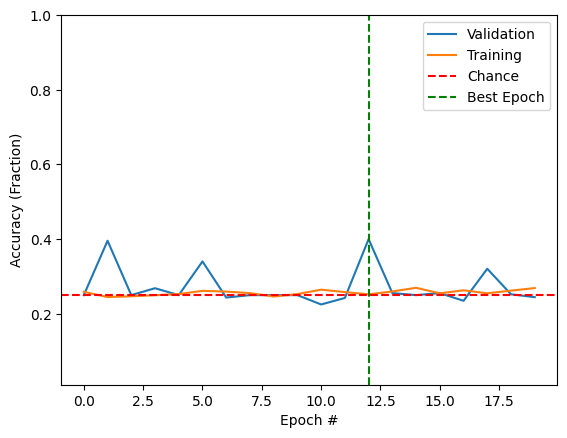

In [ ]:

plot_acc(vgg_model.history)